# Simple translation of XSPEC code

In [9]:
import numpy as np
from astropy.io import fits
from bb_astromodels.utils.data_files import _get_data_file_path
import os
class warmabs(object):
    
    def __init__(self, Xi, Temp, ionSpectrum, X):
        #load files
        self._load()
        
        # absorber ionization state = L/nR^2
        self._xi = Xi
        
        # Temp of absorber
        self._temp = Temp

        
        # I think the energy edges of the ionizing spectrum
        self._X = X
        # I am not sure what this is. Connected to ionizing spectrum
        # d(F(E)*E**2)/dE?
        self._ionSpectrum = ionSpectrum
        
        self._setup()
        
    def _setup(self):
        
        ###################### if gamma of ionizing spectrum free
        Nenergy = len(self._energy)
        spec = np.zeros(Nenergy)
        
        # Average Energy of ionizing input spectrum in all ebins (NOT GRB SPECTRUM)
        evEnergy = self._X * 5.11e5
        
        i = 0
        denom = 0
        
        
        num = -1*np.ones((len(self._atomicnumber), 
                       int(np.max(self._atomicnumber))))

        # fill spectrum for the energies in the database
        for k in range(Nenergy):
            if self._energy[k] >= evEnergy[0] and self._energy[k] <= evEnergy[len(evEnergy)-1]:
                # Look for the index of the first energy in the input energy array
                # => evEnergy[i-1] < self._energy[k] < evEnergy[i]
                while evEnergy[i] < self._energy[k]:
                    i+=1
                
                
                spec[k] = ((self._ionSpectrum[i-1]*(evEnergy[i]-self._energy[k]) +
                           self._ionSpectrum[i]*(self._energy[k]-evEnergy[i-1]))
                           /(evEnergy[i]-evEnergy[i-1])/ self._energy[k])
                # (f(i-1)*(e(i)-E)+f(i)*(E-e(i-1)))/(e(i)-e(i-1))/E
                if k==0:
                    spec[k] *= (self._energy[k+1]-self._energy[k])
                elif k==Nenergy-1:
                    spec[k] *= (self._energy[k]-self._energy[k-1])
                else:
                    spec[k] *= (self._energy[k+1]-self._energy[k-1])/2.0
                denom += spec[k]
      
        spec /= denom*self._energy

        ###################### end precalc
        
        ########### if ionization state free
        # log of absorber ionization state
        if self._xi <= 0:
            xil = -100.0
        else:
            xil = np.log(self._xi)
            
        ###############
        
        ############ if T is free
        # temperature in units of 10**-4 K
        t4 = self._temp*0.0001
        tfact = 1.033E-3/np.sqrt(t4)
        
        ########################
        #### if T, xi or gamma is free
        if False:
            mask_valid = np.zeros_like(self._ion[:,:,0], dtype=bool)
            for i, n in enumerate(self._atomicnumber):
                mask_valid[i,:n]=True

            mask_2 = np.zeros_like(self._ion[:,:,0], dtype=bool)
            for i, n in enumerate(self._atomicnumber-1):
                mask_2[i,n] = True

            # loop over all types of atoms in the model
            e1 = np.exp(-self._ion[:,:,4]/t4)
            e2 = np.exp(-self._ion[:,:,6]/t4)
            arec = (self._ion[:,:,1]*np.power(t4, -self._ion[:,:,2])+
                    self._ion[:,:,3]*np.power(t4, -1.5)*
                    e1*(1.0+self._ion[:,:,5]*e2))
            z2 = self._atomicnumber**2
            y = 15.8*z2/t4
            arec2 = tfact*z2*(1.735+np.log(y)+1/(6.*y))
            arec[mask_2] = arec2
            intgral = np.sum(self._sigma*spec, axis=2)
            ratio = np.log(3.2749e-6*intgral/arec)
            ratsum = np.sum(ratio, axis=1)
            ratcumsum = np.cumsum(ratio, axis=1)
            mul = ratcumsum + (np.arange(1,27))*xil
            mul[~mask_valid] = -10**99
            mult = np.max(mul, axis=1)
            mul = (mul.T-mult).T
            emul = np.exp(mul)
            emul[~mask_valid] = 0
            s=np.sum(emul, axis=1)

            s+=np.exp(-mult)

            num[:,0] = -mult-np.log(s)
            for j in range(1, 26):
                num[:,j] = num[:,j-1]+ratio[:,j-1]+xil
            num = np.exp(num)

        else:
            for i in range(len(self._atomicnumber)):
                mult = 0.0
                ratsum = 0.0
                # number of ionization states
                Ne = int(self._atomicnumber[i])
                mul = np.zeros(Ne)
                ratio = np.zeros(Ne)

                # for every ionization state
                for j in range(Ne):
                    intgral = 0.0
                    for k in range(Nenergy):
                        intgral += self._sigma[i,j,k]*spec[k]
                    if j<Ne-1:
                        e1 = np.exp(-self._ion[i,j,4]/t4)
                        e2 = np.exp(-self._ion[i,j,6]/t4)
                        arec = (self._ion[i,j,1]*np.power(t4, -self._ion[i,j,2])+
                                self._ion[i,j,3]*np.power(t4, -1.5)*
                                e1*(1.0+self._ion[i,j,5]*e2))
                    else:
                        z2 = self._atomicnumber[i]**2
                        y = 15.8*z2/t4
                        arec = tfact*z2*(1.735+np.log(y)+1/(6.*y))

                    ratio[j] = np.log(3.2749e-6*intgral/arec)
                    ratsum += ratio[j]
                    mul[j] = ratsum + (j+1)*xil
                    if mul[j]>mult:
                        mult = mul[j]

                s = 0.0
                for j in range(Ne):
                    mul[j] -= mult
                    s += np.exp(mul[j])

                s += np.exp(-mult)
                num[i,0] = -mult-np.log(s)
                for j in range(1, Ne):
                    num[i,j] = num[i,j-1]+ratio[j-1]+xil
                for j in range(Ne):
                    num[i,j] = np.exp(num[i,j])
        self._num = num
        ###################
        
    def get_opacity(self, inputEnergy, Abundance, IronAbundance, IncludeHHE):
        #inputEnergy: Redshifted input energies (from grb spectrum)
        
        ######### precalc
        abund = np.zeros(len(self._atomicnumber))
        opacity = np.zeros(len(inputEnergy))

        for i in range(len(abund)):
            abund[i] = self._get_abundance(self._elementname[i])
            if self._atomicnumber[i] == 26:
                abund[i] *= np.power(10.0, IronAbundance)
            elif self._atomicnumber[i]>2:
                abund[i] *= np.power(10.0, Abundance)
            else:
                if not IncludeHHE:
                    abund[i] = 0.0
        k = 0
        EnergyMax = self._energy[-1]
        EnergyMin = self._energy[0]
        ############
        
        #### if T, xi, gamma or abundance is free
        for ie in range(len(inputEnergy)):
            xp = inputEnergy[ie]*5.11e5
            if xp >= EnergyMax:
                re = np.power((xp/EnergyMax),-3.0)
                for i in range(len(self._atomicnumber)):
                    rp = abund[i]*re
                    for j in range(self._atomicnumber[i]):
                        opacity[ie] += self._num[i,j]*self._sigma[i,j,720]*rp
            elif xp < EnergyMin:
                opacity[ie] = 1.0e20;

            else:
                # Pick the closest energy bin
                while self._energy[k]<xp:
                    k+=1
                re = (xp-self._energy[k-1])/(self._energy[k]-self._energy[k-1])
                for i in range(len(self._atomicnumber)):
                    rp1 = abund[i] * re
                    rp2 = abund[i] * (1.0 - re)
                    for j in range(self._atomicnumber[i]):
                         opacity[ie] += self._num[i,j]*(rp1*self._sigma[i,j,k] + 
                                                        rp2*self._sigma[i,j,k-1]);

        opacity *= 6.6e-5
        ############
        return opacity  
    
    def _get_abundance(self, element, name="angr"):
        with open(_get_data_file_path(os.path.join("abundance", "abundances.dat"))) as f:
            rows = f.readlines()
            ele = np.array(rows[0].split(" "), dtype=str)
            ele = ele[ele!=""][1:]
            # get rid of \n at the end
            ele[-1] = ele[-1][:2]
            vals = np.zeros((7, len(ele)))
            keys = []
            for i, row in enumerate(rows[1:8]):
                l = np.array(row.split(" "), dtype=str)
                l = l[l!=""]
                # get rid of \n at the end
                if l[-1][-2:]=="\n":
                    l[-1] = l[-1][:2]
                if l[-1]=="\n":
                    l = l[:-1]
                vals[i] = np.array(l[1:], dtype=float)
                keys.append(l[0][:-1])
            keys = np.array(keys)
        assert element in ele, f"{element} not a valid element. Valid elements: {ele}"
        
        idx = np.argwhere(ele==element)[0,0]
        
        assert name in keys, f"{name} not a valid name. Valid names: {keys}"
        
        idy = np.argwhere(keys==name)[0,0]
        
        return vals[idy, idx]
        
    def _load(self):
        ion = np.zeros((10, 26, 10))
        sigma = np.zeros((10, 26, 721))
        atomicnumber = np.empty(10, dtype=int)

        with fits.open(_get_data_file_path(os.path.join("ionized", "mansig.fits"))) as f:
            znumber = f["SIGMAS"].data["Z"]
            ionnumber =  f["SIGMAS"].data["ION"]
            sigmadata =  f["SIGMAS"].data["SIGMA"]
            iondata =  f["SIGMAS"].data["IONDATA"]
            
            energy =  f["ENERGIES"].data["ENERGY"]
            
        currentZ = -1
        iZ=-1
        iIon=-1
        for i in range(len(znumber)):
            if znumber[i]!=currentZ:
                iZ+=1
                atomicnumber[iZ] = znumber[i]
                currentZ = znumber[i]
                iIon = -1
            iIon+=1
            for k in range(10):
                ion[iZ,iIon,k] = iondata[i][k]
                
            # change units of coef
            
            ion[iZ][iIon][1] *= 1.0E+10;
            ion[iZ][iIon][3] *= 1.0E+04;
            ion[iZ][iIon][4] *= 1.0E-04;
            ion[iZ][iIon][6] *= 1.0E-04;
            
            for k in range(721):
                sigma[iZ][iIon][k] = sigmadata[i][k]/6.6e-27
                
        self._elementname = ["H", "He", "C", "N", "O", "Ne", "Mg", "Si", "S", "Fe"]
        
        self._ion = ion
        self._sigma = sigma
        self._atomicnumber = atomicnumber
        self._energy = energy

        
def calc_powerlaw(powE, gamma, renorm, powF):
    """
    I think this only integrates a powerlaw with index Gamma between the ebounds
    given in powE
    """
    assert not renorm, "Renorm not implemented"
    alpha = 1-gamma
    N = len(powE)
    if abs(alpha) < 1e-10:
        logE = np.log(powE)
        first = logE[0]
        for i in range(1, N): #(size_t i = 1; i < N; ++i) {
            second = logE[i]
            powF[i - 1] = second - first
            first = second
    else:
        alphani = 1./alpha;
        first = alphani*np.power(powE[0],alpha);
        for i in range(1, N):
            second = (alphani*np.power(powE[i],alpha))
            powF[i - 1] = second - first
            first =  second
        
    return powF


def xsabsori(energyarray, params):
    # Read in parameters
    gamma, nh, temp, xi, z, abundance, fe_abundance = params
    z += 1
    #fe_abundance = np.log10(fe_abundance)
    N = len(energyarray)-1
    
    
    # Define ionizing spectrum
    powN = 5000
    powE = np.zeros(powN+1)
    powF = np.zeros(powN)
    
    dellog= (np.log(20.0)-np.log(0.005))/(powN+1)
    
    for i in range(powN+1):
        powE[i] = np.power(10.0, np.log(0.005)+i*dellog)
    
    powF = calc_powerlaw(powE, gamma, False, powF);
    
    
    X = np.zeros(powN)
    Spinc = np.zeros(powN)
    # Why /511? => gets multiplied with 511 again in the setup method
    factor = 1.0/(2.0*511.0)
    
    for i in range(powN):
        X[i] = (powE[i+1]+powE[i]) * factor;
        
    for i in range(powN):
        if powE[i+1]!=powE[i]:
            avgE = (powE[i+1]+powE[i])/2.
            Spinc[i] = powF[i]*avgE*avgE/(powE[i+1]-powE[i])   
    
    # Use the ionizing spectrum, the temp and the ionization state of the 
    # absorper to define the warmabs 
    wa = warmabs(xi, temp, Spinc, X)
    # Calc the mean of the redshifted ebins of the grb spectrum
    input_energies = np.zeros(N)
    factor = z/(2.0*511.0)
    for i in range(N):
        input_energies[i] = (energyarray[i+1]+energyarray[i]) * factor 
        
    #Abund = 0
    # use the redshifted ebins and the abundance to calc the opacity
    opacity = wa.get_opacity(input_energies, abundance, fe_abundance, True)
    
    # weird name; only the absorption 
    flux = np.exp(-nh * opacity)
    return flux
    
    
def integrate(energybounds, n0, gamma, nH, temp, xi, z, h0, 
              omegam, omegal, abundance, fe_abundance):
    cmpermpc=3.08568e24
    c=2.99792458e5
    taus = np.zeros(len(energybounds)-1)
    nz = int(z/0.02)
    zsam = z/nz
    zz = zsam*0.5
    for i in range(nz):
        z1 = zz+1.0
        zf = (z1**2/np.sqrt(omegam*z1**3+omegal))
        zf *= zsam*c*n0*cmpermpc/h0
        params = [gamma, nH, temp, xi, zz, abundance, fe_abundance]
        xsec = xsabsori(energybounds, params)
        xsec = -np.log(xsec)*1.e-22/params[1]
        taus += xsec*zf
        zz+=zsam
    return taus

# bb astromodels imports

In [10]:
from bb_astromodels.xray.absorption import absori, integrate_absori

# Compare simple absori model

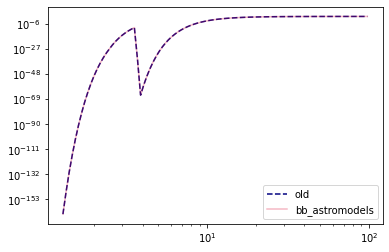

In [11]:
# params - can change these
gamma = 4
nh=100
temp=1000
z=1
fe_abundance=2
abundance=0
xi=1000
energyarray = np.logspace(0.1,2,100)

# simple translation run
params = [gamma, nh, temp, xi, z, abundance, fe_abundance]

xsabso = xsabsori(energyarray, params)

# bb astromodels run
x = (energyarray[1:]+energyarray[:-1])/2
astroabso = absori().evaluate(x=x, NH=nh, redshift=z, temp=temp, xi=xi, 
                              gamma=gamma, abundance=abundance, fe_abundance=fe_abundance)

# plot result
import matplotlib.pyplot as plt
plt.loglog(x, xsabso, "--", color="navy", label="old")
plt.loglog(x, astroabso, alpha=0.3, color="crimson", label="bb_astromodels")
plt.legend()

# Compare integrated absori model (IGM)

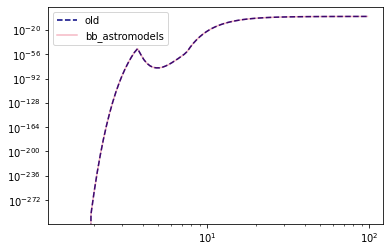

In [12]:
# params - can change these
gamma = 2
n0=1e-3
temp=1000
z=1
fe_abundance=1
abundance=-1
xi=10
energyarray = np.logspace(0.1,2,100)


# simple translation run
xsint_abso = np.exp(-integrate(energyarray, n0, gamma, 10, temp, xi, z, 70, 
                              0.3,0.7, abundance, fe_abundance))

# bb astromodels run
x = (energyarray[1:]+energyarray[:-1])/2
astro_intabso = integrate_absori().evaluate(x=x, n0=n0, redshift=z, temp=temp, xi=xi, 
                              gamma=gamma, abundance=abundance, fe_abundance=fe_abundance)

# plot result
import matplotlib.pyplot as plt
plt.loglog(x, xsint_abso, "--", color="navy", label="old")
plt.loglog(x, astro_intabso, alpha=0.3, color="crimson", label="bb_astromodels")
plt.legend()

# Eval. time

In [14]:
# simple absori
a = absori()
%%timeit a.evaluate(x=x, NH=nh, redshift=z, temp=temp, xi=xi, gamma=gamma, abundance=abundance, fe_abundance=fe_abundance)

UsageError: Line magic function `%%timeit` not found.
